# Testing Object Localization

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

In [2]:
import numpy as np
import os
import tensorflow as tf
from handle_dataset import HandleDataFolder

class Train:
    __xs = []
    __ys = []
    __x_ = []
    __y_box = []
    __y_obj = []
    __is_training = []
    __model_box = []
    __model_has_obj = []
    __session = []
    __train_step = []
    __loss = []
    __merged_summary_op = []
    __writer = []
    __saver = []

    def build_graph(self):
        self.__x_ = tf.placeholder("float", shape=[None, 240, 320, 3], name='X')
        self.__y_box = tf.placeholder("float", shape=[None, 4], name='Y_box')
        self.__y_obj = tf.placeholder("float", shape=[None, 1], name='Y_obj')
        # Add dropout to the fully connected layer
        self.__is_training = tf.placeholder(tf.bool)

        with tf.name_scope("model") as scope:
            conv1 = tf.layers.conv2d(inputs=self.__x_, filters=32, kernel_size=[5, 5],
                                     padding="same", activation=tf.nn.relu)

            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

            conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5],
                                     padding="same", activation=tf.nn.relu)

            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

            conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[5, 5],
                                     padding="same", activation=tf.nn.relu)

            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

            pool3_flat = tf.reshape(pool3, [-1, 40 * 30 * 32])

            # 2 Head version (has object head, and bouding box)
            self.__model_box = tf.layers.dense(inputs=pool3_flat, units=4)
            self.__model_has_obj = tf.layers.dense(inputs=pool3_flat, units=1, activation=tf.nn.sigmoid)

        with tf.name_scope("loss_func") as scope:
            loss_obj = tf.losses.log_loss(labels=self.__y_obj, predictions=self.__model_has_obj)
            loss_bbox = tf.losses.huber_loss(labels=self.__y_box, predictions=self.__model_box)
            # Get ratio of samples with objects
            batch_size = tf.cast(tf.shape(self.__y_obj)[0], tf.float32)
            num_objects_label = tf.cast(tf.count_nonzero(tf.cast(self.__y_obj > 0.0, tf.float32)), tf.float32)
            print(num_objects_label)

            ratio_has_objects = (num_objects_label * tf.constant(100.0)) / batch_size

            # Loss function that has an "ignore" factor on the bbox loss when objects is not detected
            self.__loss = loss_obj + (loss_bbox*ratio_has_objects)

            # Add loss to tensorboard
            tf.summary.scalar("loss", self.__loss)
            tf.summary.scalar("loss_bbox", loss_bbox)
            tf.summary.scalar("loss_obj", loss_obj)

        with tf.name_scope("optimizer") as scope:
            self.__train_step = tf.train.AdamOptimizer(1e-4).minimize(self.__loss)

        # Merge op for tensorboard
        self.__merged_summary_op = tf.summary.merge_all()

        # Build graph
        init = tf.global_variables_initializer()

        # Saver for checkpoints
        self.__saver = tf.train.Saver(max_to_keep=None)

        # Avoid allocating the whole memory
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
        self.__session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        # Configure summary to output at given directory
        self.__writer = tf.summary.FileWriter("./logs/loc_logs", self.__session.graph)
        self.__session.run(init)

    def train(self, path='./dataset/', save_dir='./save'):
        data = HandleDataFolder()
        self.__xs, self.__ys = data.load_dataset(path)
        self.build_graph()
        # Train
        for i in range(2000):
            if i % 100 == 0:
                loss_val, summary = self.__session.run([self.__loss, self.__merged_summary_op],
                                                       feed_dict={self.__x_: self.__xs,
                                                                  self.__y_obj: self.__ys[:, 0].reshape(-1, 1),
                                                                  self.__y_box: self.__ys[:, 1:],
                                                                  self.__is_training: False})
                print("Loss: {}".format(loss_val))
                # Write to tensorboard summary
                self.__writer.add_summary(summary, i)
            self.__train_step.run(session=self.__session,feed_dict={self.__x_: self.__xs,
                                                                    self.__y_obj: self.__ys[:, 0].reshape(-1,1),
                                                                    self.__y_box: self.__ys[:, 1:],
                                                                    self.__is_training: False})
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        checkpoint_path = os.path.join(save_dir, "model")
        filename = self.__saver.save(self.__session, checkpoint_path)
        print("Model saved in file: %s" % filename)

    @property
    def out_box(self):
        return self.__model_box

    @property
    def out_has_obj(self):
        return self.__model_has_obj

    @property
    def input(self):
        return self.__x_

    @property
    def label_in_bbox(self):
        return self.__y_box

    @property
    def label_in_obj(self):
        return self.__y_obj

    @property
    def num_parameters(self):
        return np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])


## Load Test image

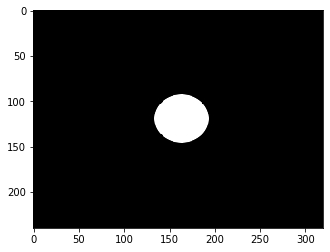

In [3]:
#test_img = scipy.misc.imread('./test_data/test_0.jpg', mode="RGB")
test_img = cv2.imread('./test_data/test_0.jpg')
plt.imshow(test_img)
plt.show()

### Build Graph and Restore saved Model

In [4]:
model = Train()
model.build_graph()
model_in = model.input
model_out_box = model.out_box
model_out_has_obj = model.out_has_obj
# Load tensorflow section
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./save/model")
print('Number of parameters:',model.num_parameters)

Tensor("loss_func/Cast_2:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from ./save/model
Number of parameters: 296933


### Evaluate model on Image

In [44]:
test_img = cv2.imread('./test_data/test_1.jpg')
box, has_obj = sess.run([model_out_box, model_out_has_obj],feed_dict={model_in: [test_img]})
print(box)
print(has_obj)

[[ 4.0021977 -5.801032  -9.118556  -1.6284099]]
[[0.]]


### Draw Bounding Box

x: -5.801032, y: 4.002198, w: -9.118556 h: -1.628410
x: -1856, y: 960, w: -2917 h: -390


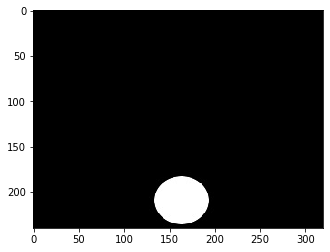

In [45]:
y,x,w,h = box[0]
print("x: %f, y: %f, w: %f h: %f" % (x,y,w,h))
x = int((x*320.0))
y = int((y*240.0))
w = int(w*320)
h = int(h*240)
print("x: %d, y: %d, w: %d h: %d" % (x,y,w,h))
cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.imshow(test_img)
plt.show()